In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls '/content/drive/MyDrive/Video/'

 Đức.mp4    Hùng.mp4   Quân.mp4    Trường.mp4  'Việt Đức.mp4'
 HĐức.mp4   Kiên.mp4   Tân.mp4     Tuấn.mp4    'Xuân Anh.mp4'
 Hiếu.mp4   Linh.mp4   Thắng.mp4   Vân.mp4


In [ ]:
folder_path = '/content/drive/MyDrive/Video/'

In [ ]:
pip install retina-face

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.13.0-py3-none-any.whl size=9046 sha256=e2ff8252931a54b2369dc0f961a247e136aab7a2ad54eaa9c299a3466affb97b
  Stored in directory: /root/.cache/pip/wheels/2f/2a/2f/86449b6bdbaa9aef873f68332b68be6bfbc386b9219f47157d
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


# Import thư viện

In [ ]:
import os
import glob
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from retinaface import RetinaFace
from tensorflow.keras.models import load_model,Sequential
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam,SGD
from keras.utils import np_utils

# Xử lý video

hàm lấy mặt từ ảnh

In [ ]:
def get_face_from_image(image_path):
  obj = RetinaFace.detect_faces(image_path)
  img = cv2.imread(image_path)
  try:
    for key in obj.keys():

      identity = obj[key]
      bounding_box = identity['facial_area']

      face = img[int(bounding_box[1]):int(bounding_box[3]),int(bounding_box[0]):int(bounding_box[2])]
      return face
  except(AttributeError):
    print('0 face')
    return

Lấy ảnh từ video

In [ ]:
#'/content/drive/MyDrive/Video/Vân.mp4'
def crop_face(path_video):
  print(path_video)
  cap = cv2.VideoCapture(path_video)
  i = 0
  while cap.isOpened():
    ret, frame = cap.read()
    if ret:
      if i%20 == 0:
        save_dir = '/content/drive/MyDrive/face_detect/'+path_video[29:-4]
        if not os.path.isdir(save_dir):
          os.makedirs(save_dir)
        cv2.imwrite(save_dir+'/image'+str(i//20)+'.png',frame)
        print(save_dir+'/image'+str(i//20)+'.png')
      i+=1
    else:
      break

for i in glob.glob('/content/drive/MyDrive/Video/'+'*'):
  crop_face(i)

Lưu ảnh mặt

In [ ]:
for folder in glob.glob('/content/drive/MyDrive/face_detect/'+'*'):
  id = 0
  print('- '+folder)
  
  save_path = '/content/drive/MyDrive/Data/' + folder[35:] #/content/drive/MyDrive/Data/Linh
  if not os.path.isdir(save_path):
    os.makedirs(save_path)
  else:
    continue
    
  for image_path in glob.glob(folder + '/*'):
    print('   + '+image_path[len(folder):])
    face  = get_face_from_image(image_path)
    cv2.imwrite(save_path+'/image'+str(id)+'.png',face)
    id +=1

# Bắt đầu

chuyển ảnh về array

In [ ]:
data = []
targets = []

label = 0
for folder in glob.glob('/content/drive/MyDrive/Data/'+'*'):
  print('- '+folder)
  for img_path in glob.glob(folder + '/*'):
    targets.append(label)
    print('   + '+img_path[len(folder):])
    face = cv2.imread(img_path)
    face = cv2.resize(face,(160,160))
    face = img_to_array(face)
    data.append(face)
  label +=1

In [ ]:
data = np.array(data)
targets = np.array(targets).reshape(-1,1)

visualize

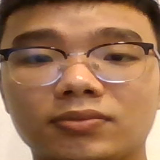

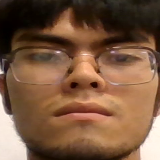

In [ ]:
cv2_imshow(data[0])
cv2_imshow(data[202])

In [ ]:
print(data.shape)
print(targets.shape)

(301, 160, 160, 3)
(301, 1)


In [ ]:
print(np.unique(targets,return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([24, 24, 24, 23, 17, 19, 19, 24, 24, 28, 28, 15, 21, 11]))


tách training set và validation set

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(data,targets,random_state = 1, test_size = 0.2, stratify = targets)

In [ ]:
np.unique(y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([19, 19, 19, 19, 14, 15, 15, 19, 19, 21, 22, 12, 17,  9]))

In [ ]:
np.unique(y_test, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([5, 5, 5, 4, 3, 4, 4, 5, 5, 5, 6, 3, 4, 2]))

# model FaceNet

In [ ]:
model = load_model('/content/drive/MyDrive/coursework1/facenet_keras.h5')

In [ ]:
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

# Lấy vector embedding từ FaceNet

In [ ]:
def get_embedding(model, face_pixels):
	face_pixels = face_pixels.astype('float32')
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	samples = np.expand_dims(face_pixels, axis=0)

	yhat = model.predict(samples)
	return yhat[0]

In [ ]:
newTrainX = []
for face_pixels in x_train:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = np.array(newTrainX)
print(newTrainX.shape)

(239, 128)


In [ ]:
newTestX = []
for face_pixels in x_test:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = np.array(newTestX)
print(newTestX.shape)

(60, 128)


# Normalize Data

In [ ]:
from sklearn.preprocessing import Normalizer, LabelEncoder

In [ ]:
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(newTrainX)
testX = in_encoder.transform(newTestX)

In [ ]:
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(y_train)
y_train = out_encoder.transform(y_train)
y_test = out_encoder.transform(y_test)

# So sánh khoảng cách giữa các embedding vector

In [ ]:
%pip install scipy

In [ ]:
from scipy.spatial.distance import cosine,euclidean

Khoảng cách trong cùng 1 class

In [ ]:
match_distances = []
for i in range(14):
  idx = np.where(y_train == i)[0]
  distances =[]
  for j in range(len(idx)-1):
    for k in range(i+1,len(idx)):
      distances.append(cosine(trainX[idx[j]],trainX[idx[k]]))
  match_distances.extend(distances)

Khoảng cách giữa các embedding vector khác class

In [ ]:
unmatch_distances = []
for i in range(14):
  idx = np.where(y_train == i)[0]
  distances =[]
  for j in range(len(idx)):
    for k in range(10):
      diff = np.random.randint(trainX.shape[0])
      while diff in idx:
        diff = np.random.randint(trainX.shape[0])

      distances.append(cosine(trainX[idx[j]], trainX[diff]) )
  unmatch_distances.extend(distances)


Biểu đồ 

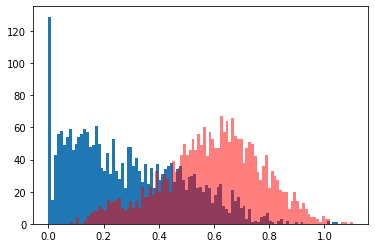

In [ ]:
import matplotlib.pyplot as plt

_,_,_=plt.hist(match_distances,bins=100)
_,_,_=plt.hist(unmatch_distances,bins=100,fc=(1, 0, 0, 0.5))

-> chọn threshold trong khoảng (0.4, 0.5)

## **--------------------------------------------------------** 

In [ ]:
np.save('./trainX.npy',trainX)
np.save('./testX.npy',testX)

# Đánh giá

In [ ]:
label = 0
_dict = []
for folder in glob.glob('/content/drive/MyDrive/Data/'+'*'):
  _dict.append((label,folder[len('/content/drive/MyDrive/Data/'):]))
  label +=1

_dict = dict(_dict)
print(_dict)

{0: 'Tuấn', 1: 'Trường', 2: 'Linh', 3: 'Hiếu', 4: 'Tân', 5: 'Đức', 6: 'Kiên', 7: 'Việt Đức', 8: 'Hùng', 9: 'Quân', 10: 'Xuân Anh', 11: 'Thắng', 12: 'Vân', 13: 'HĐức'}


chuyển về không dấu (cv2 không nhận font tiếng việt)

In [ ]:
_dict = {0: 'Tuan', 1: 'Truong', 2: 'Linh', 3: 'Hieu', 4: 'Tan', 5: 'Duc', 6: 'Kien', 7: 'Viet Duc', 8: 'Hung', 9: 'Quan', 10: 'Xuan Anh', 11: 'Thang', 12: 'Van', 13: 'HDuc'}

Đánh giá trên tập validation

True name:  Tuấn
Predict name:  Tuấn
cosine distance:  0.13499563932418823


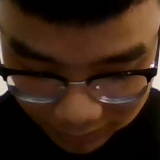

------------------------------------------------------------------------
True name:  Xuân Anh
Predict name:  Xuân Anh
cosine distance:  0.016916751861572266


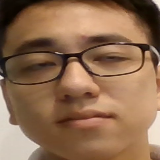

------------------------------------------------------------------------
True name:  Tuấn
Predict name:  Tuấn
cosine distance:  0.027421653270721436


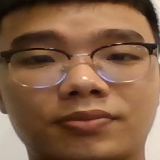

------------------------------------------------------------------------
True name:  Vân
Predict name:  Vân
cosine distance:  0.0074256062507629395


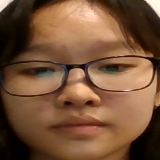

------------------------------------------------------------------------
True name:  HĐức
Predict name:  HĐức
cosine distance:  0.02030414342880249


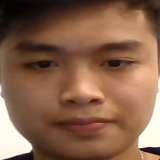

------------------------------------------------------------------------
True name:  Quân
Predict name:  Quân
cosine distance:  0.024337410926818848


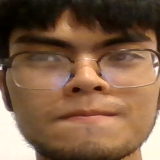

------------------------------------------------------------------------
True name:  Kiên
Predict name:  Kiên
cosine distance:  0.09955620765686035


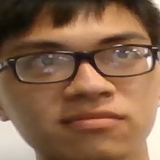

------------------------------------------------------------------------
True name:  Vân
Predict name:  Vân
cosine distance:  0.0646355152130127


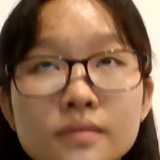

------------------------------------------------------------------------
True name:  Quân
Predict name:  Quân
cosine distance:  0.19124019145965576


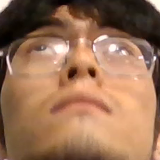

------------------------------------------------------------------------
True name:  Linh
Predict name:  Linh
cosine distance:  0.02827775478363037


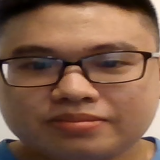

------------------------------------------------------------------------
True name:  Việt Đức
Predict name:  Việt Đức
cosine distance:  0.06133753061294556


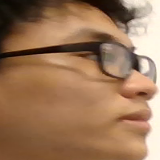

------------------------------------------------------------------------
True name:  Quân
Predict name:  Quân
cosine distance:  0.4143129587173462


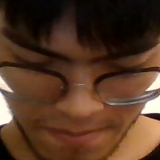

------------------------------------------------------------------------
True name:  Đức
Predict name:  Đức
cosine distance:  0.022229909896850586


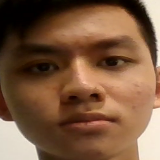

------------------------------------------------------------------------
True name:  HĐức
Predict name:  HĐức
cosine distance:  0.014796257019042969


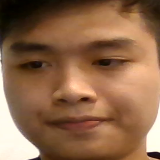

------------------------------------------------------------------------
True name:  Tân
Predict name:  Tân
cosine distance:  0.06678587198257446


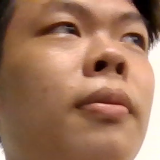

------------------------------------------------------------------------
True name:  Xuân Anh
Predict name:  Xuân Anh
cosine distance:  0.05987757444381714


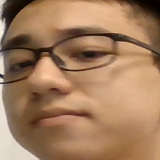

------------------------------------------------------------------------
True name:  Việt Đức
Predict name:  Việt Đức
cosine distance:  0.1492455005645752


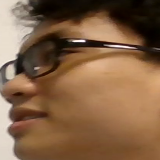

------------------------------------------------------------------------
True name:  Thắng
Predict name:  Thắng
cosine distance:  0.03343343734741211


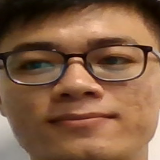

------------------------------------------------------------------------
True name:  Xuân Anh
Predict name:  Xuân Anh
cosine distance:  0.2122284173965454


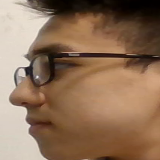

------------------------------------------------------------------------
True name:  Linh
Predict name:  Linh
cosine distance:  0.0322108268737793


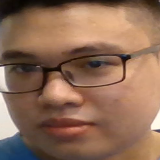

------------------------------------------------------------------------
True name:  Vân
Predict name:  Vân
cosine distance:  0.10490942001342773


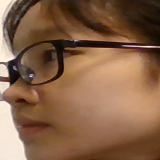

------------------------------------------------------------------------
True name:  Kiên
Predict name:  Kiên
cosine distance:  0.16939181089401245


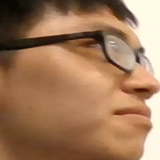

------------------------------------------------------------------------
True name:  Tuấn
Predict name:  Tuấn
cosine distance:  0.013880372047424316


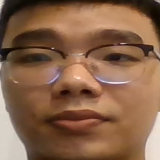

------------------------------------------------------------------------
True name:  Hiếu
Predict name:  Hiếu
cosine distance:  0.07031989097595215


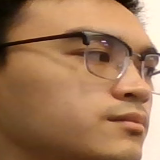

------------------------------------------------------------------------
True name:  Hiếu
Predict name:  Hiếu
cosine distance:  0.06882762908935547


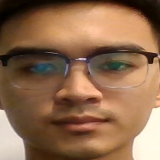

------------------------------------------------------------------------
True name:  Tân
Predict name:  Tân
cosine distance:  0.04982393980026245


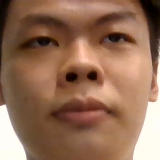

------------------------------------------------------------------------
True name:  Xuân Anh
Predict name:  Xuân Anh
cosine distance:  0.07677698135375977


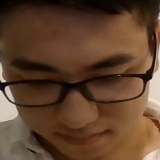

------------------------------------------------------------------------
True name:  Vân
Predict name:  Vân
cosine distance:  0.006711363792419434


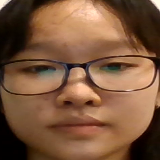

------------------------------------------------------------------------
True name:  Hùng
Predict name:  Tân
cosine distance:  0.3219524025917053


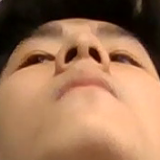

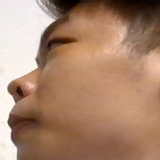

------------------------------------------------------------------------
True name:  Trường
Predict name:  Trường
cosine distance:  0.07652288675308228


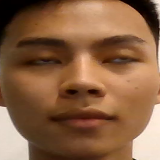

------------------------------------------------------------------------
True name:  Hùng
Predict name:  Hùng
cosine distance:  0.020639121532440186


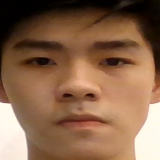

------------------------------------------------------------------------
True name:  Việt Đức
Predict name:  Việt Đức
cosine distance:  0.01354759931564331


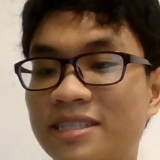

------------------------------------------------------------------------
True name:  Thắng
Predict name:  Thắng
cosine distance:  0.1091967225074768


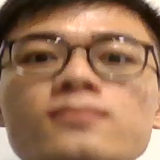

------------------------------------------------------------------------
True name:  Linh
Predict name:  Linh
cosine distance:  0.07334858179092407


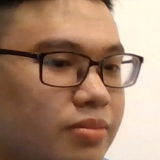

------------------------------------------------------------------------
True name:  Tuấn
Predict name:  Tuấn
cosine distance:  0.1271457076072693


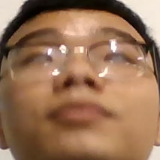

------------------------------------------------------------------------
True name:  Linh
Predict name:  Linh
cosine distance:  0.014466404914855957


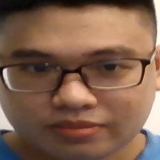

------------------------------------------------------------------------
True name:  Thắng
Predict name:  Thắng
cosine distance:  0.2899608016014099


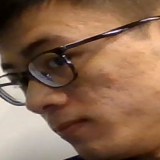

------------------------------------------------------------------------
True name:  Tân
Predict name:  Tân
cosine distance:  0.018632471561431885


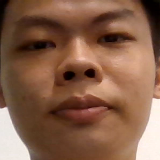

------------------------------------------------------------------------
True name:  Việt Đức
Predict name:  Việt Đức
cosine distance:  0.14850366115570068


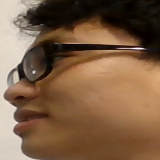

------------------------------------------------------------------------
True name:  Quân
Predict name:  Quân
cosine distance:  0.06507796049118042


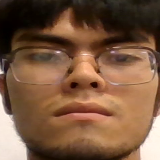

------------------------------------------------------------------------
True name:  Việt Đức
Predict name:  Việt Đức
cosine distance:  0.03171348571777344


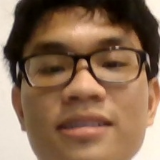

------------------------------------------------------------------------
True name:  Tuấn
Predict name:  Tuấn
cosine distance:  0.09806925058364868


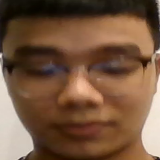

------------------------------------------------------------------------
True name:  Trường
Predict name:  Trường
cosine distance:  0.08071315288543701


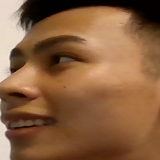

------------------------------------------------------------------------
True name:  Kiên
Predict name:  Kiên
cosine distance:  0.04908549785614014


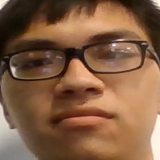

------------------------------------------------------------------------
True name:  Hiếu
Predict name:  Hiếu
cosine distance:  0.16007232666015625


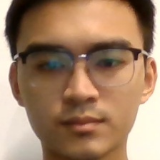

------------------------------------------------------------------------
True name:  Xuân Anh
Predict name:  Xuân Anh
cosine distance:  0.02113896608352661


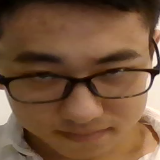

------------------------------------------------------------------------
True name:  Quân
Predict name:  Quân
cosine distance:  0.052340805530548096


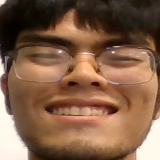

------------------------------------------------------------------------
True name:  Hiếu
Predict name:  Hiếu
cosine distance:  0.06375294923782349


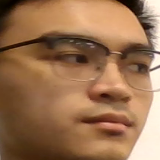

------------------------------------------------------------------------
True name:  Hùng
Predict name:  Hùng
cosine distance:  0.015364468097686768


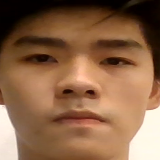

------------------------------------------------------------------------
True name:  Kiên
Predict name:  Kiên
cosine distance:  0.1290191411972046


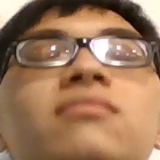

------------------------------------------------------------------------
True name:  Đức
Predict name:  Đức
cosine distance:  0.014048337936401367


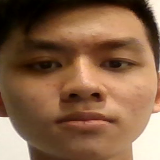

------------------------------------------------------------------------
True name:  Xuân Anh
Predict name:  Xuân Anh
cosine distance:  0.050223588943481445


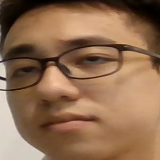

------------------------------------------------------------------------
True name:  Trường
Predict name:  Trường
cosine distance:  0.0732150673866272


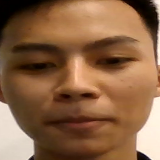

------------------------------------------------------------------------
True name:  Hùng
Predict name:  Hùng
cosine distance:  0.06837129592895508


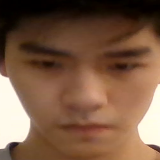

------------------------------------------------------------------------
True name:  Trường
Predict name:  Trường
cosine distance:  0.1210055947303772


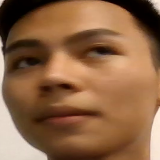

------------------------------------------------------------------------
True name:  Đức
Predict name:  Đức
cosine distance:  0.0140114426612854


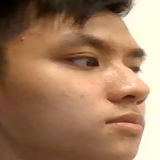

------------------------------------------------------------------------
True name:  Trường
Predict name:  Trường
cosine distance:  0.2412150502204895


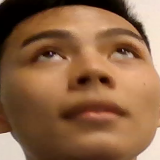

------------------------------------------------------------------------
True name:  Hùng
Predict name:  Hùng
cosine distance:  0.07425498962402344


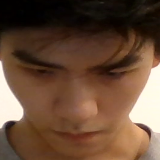

------------------------------------------------------------------------
True name:  Linh
Predict name:  Linh
cosine distance:  0.054973065853118896


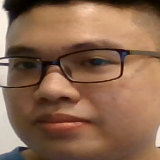

------------------------------------------------------------------------
True name:  Đức
Predict name:  Đức
cosine distance:  0.04258030652999878


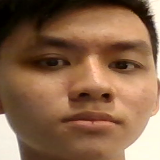

------------------------------------------------------------------------
True name:  Quân
Predict name:  Quân
cosine distance:  0.036049067974090576


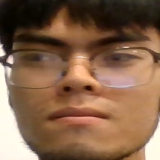

------------------------------------------------------------------------
accuracy:  0.9836065573770492


In [ ]:
num_true = 0
for i in range(len(newTestX)):
  tmp = 100
  index = 0
  for j in range(len(newTrainX)):
    dis = cosine(newTestX[i],newTrainX[j])
    if dis < tmp:
      tmp = dis
      index = j
  
  if tmp > 0.5:
    print('unknown')


  else:
    print('True name: ',_dict[y_test[i][0]])
    print('Predict name: ',_dict[y_train[index][0]])
    print('cosine distance: ',tmp)
    cv2_imshow(x_test[i])
    if y_test[i] == y_train[index]:#y_train[index] là nhãn của ảnh gần với input nhất # nếu dự đoán đúng
      num_true +=1
  
    else: # nếu dự đoán sai, in ra ảnh sai
      cv2_imshow(x_train[index])
  
  print('------------------------------------------------------------------------')
print('accuracy: ',num_true/len(y_test))

# Predict new image

**Note: Load trainX và testX trong cùng folder**

In [ ]:
from scipy.spatial.distance import cosine,euclidean
from sklearn.preprocessing import Normalizer, LabelEncoder
def get_embedding(model, face_pixels):
	face_pixels = face_pixels.astype('float32')
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	samples = np.expand_dims(face_pixels, axis=0)

	yhat = model.predict(samples)
	return yhat[0]

Predict khuôn mặt

In [ ]:
def predict(model,face):
  embedding_vector = get_embedding(model, face).reshape(-1,1) # lấy vector embedding
  embedding_vector = Normalizer(norm='l2').transform(embedding_vector) # chuẩn hóa

  tmp = 100 # khởi tạo giá trị cho distance
  index = 0 #khởi tạo id 
  for j in range(len(newTrainX)):
    dis = cosine(embedding_vector,newTrainX[j])
    if dis < tmp:
      tmp = dis
      index = j
  
  if tmp > 0.4:
    return 'unknown'
  else:
    return _dict[y_train[index][0]]


Nhận diện trên ảnh

In [ ]:
def recognize_from_image(model,image_path):
  obj = RetinaFace.detect_faces(image_path)
  img = cv2.imread(image_path)
  faces = []
  try:
    for key in obj.keys():

      identity = obj[key]
      bounding_box = identity['facial_area']

      face = img[int(bounding_box[1]):int(bounding_box[3]),int(bounding_box[0]):int(bounding_box[2])]

      face = cv2.resize(face,(160,160))

      id = predict(model,face)

      cv2.rectangle(img,
                    (bounding_box[2],bounding_box[3]),
                    (bounding_box[0],bounding_box[ 1]),
                    [255,0,0],thickness = 2)
      

      Y = bounding_box[1] - 10 if bounding_box[1] - 10 > 10 else bounding_box[1] + 10

      cv2.putText(img, id, (bounding_box[0], Y), cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (0, 255, 0), 2)
      

      faces.append(face)
    return img
      
  except(AttributeError):
    print('0 face')
    return

Ví dụ

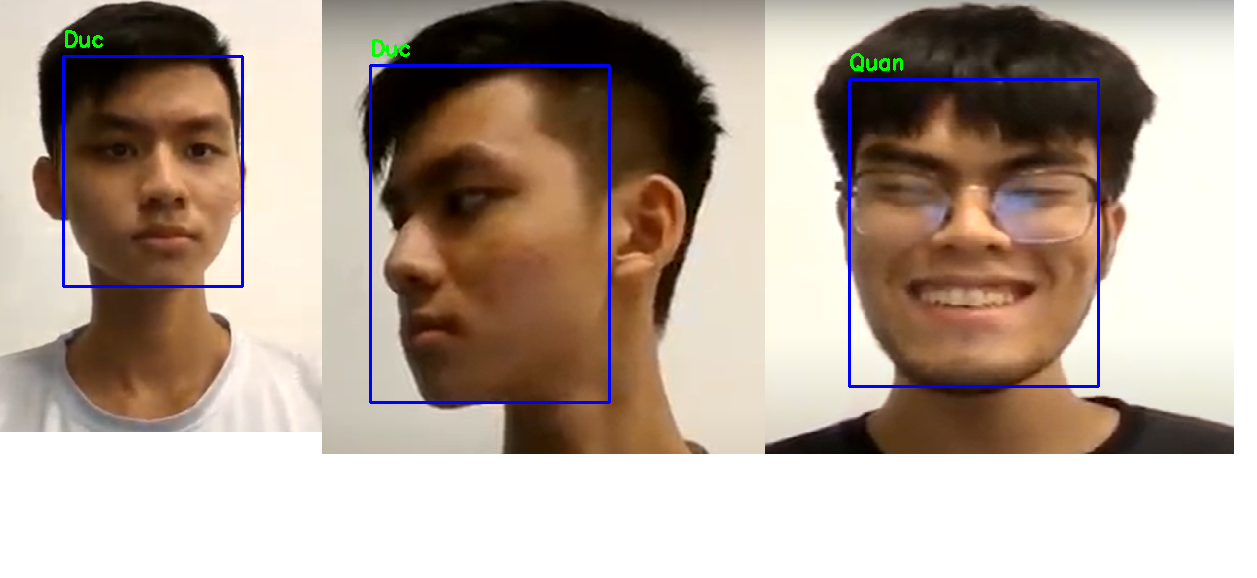

In [ ]:
faces = recognize_from_image(model,'Untitled.png')
cv2_imshow(faces)

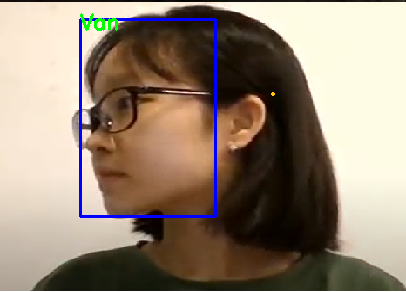

In [ ]:
faces = recognize_from_image(model,'test4.png')
cv2_imshow(faces)

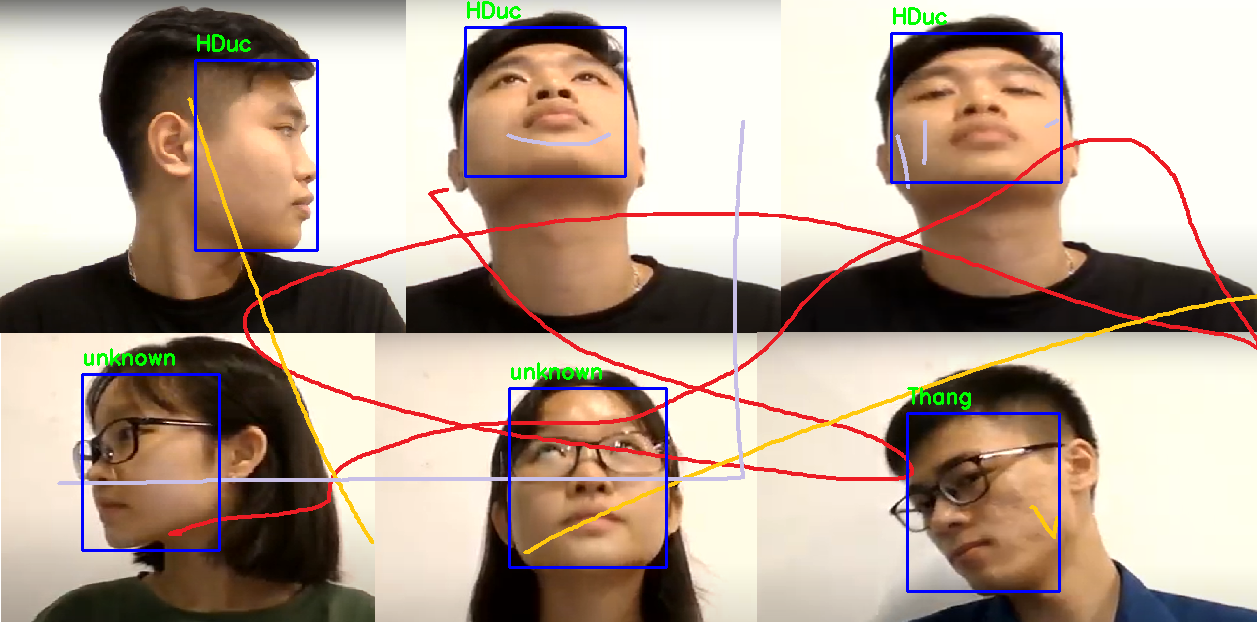

In [ ]:
faces = recognize_from_image(model,'test5.png')
cv2_imshow(faces)

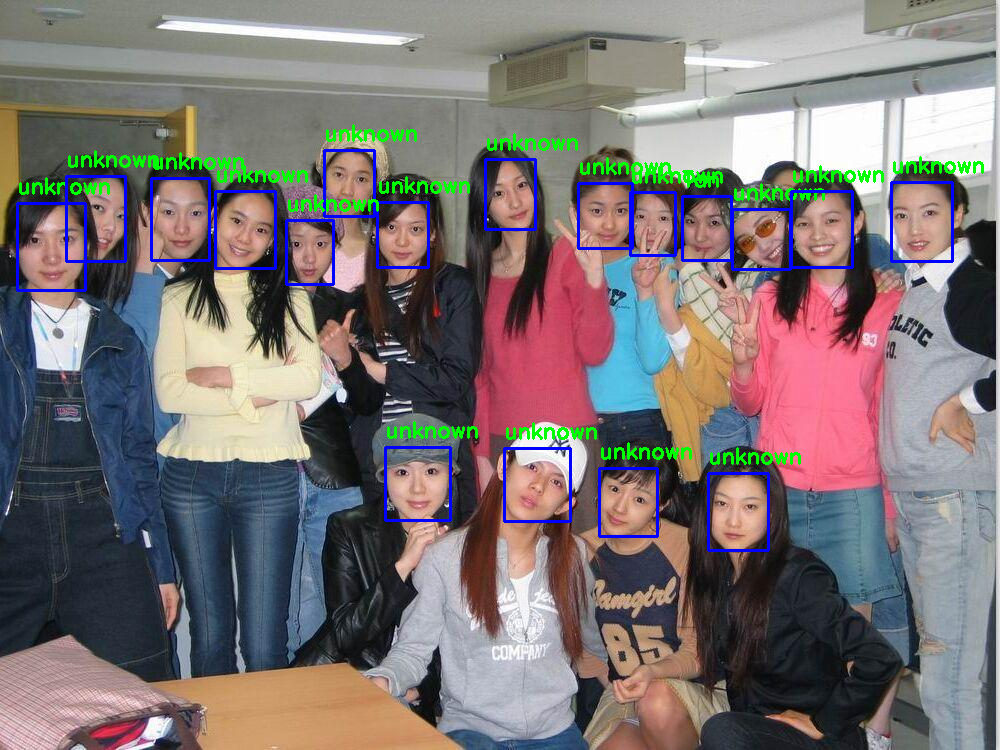

In [ ]:
faces = recognize_from_image(model,'test6.jpg')
cv2_imshow(faces)

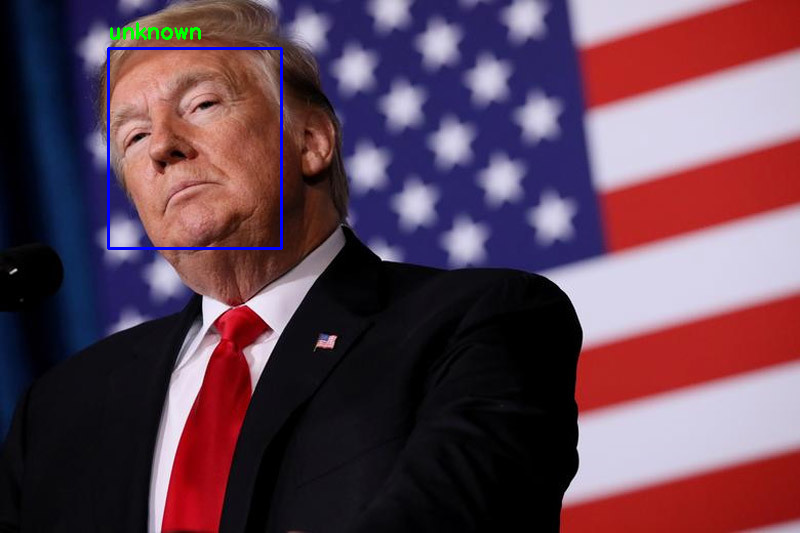

In [ ]:
faces = recognize_from_image(model,'trump.jpg')
cv2_imshow(faces)